# Analysis for China wage vs. education data

#### Since R cannot be ran on normal VS code, I had to install visual studio code insider for it!

## Datasets used

From Dropbox: China-Education-Wages -> Data -> CFPS Data 2010-2016

Downloaded:
- 2010 Egnlish -> ecfps2010adult_112014.dta     
  - Renamed 2010adult.dta
- 2012 Egnlish -> ecfps2012adultcombine…015.dta     
  - Renamed 2012adult.dta
- 2014 English -> ecfps2014adult_170630.dta     
  - Renamed 2014adult.dta
- Mincer16 -> Mincer16.csv 

All 4 datasets were put within one folder named $CFPSdata$ in the same layer as this jupyter notebook.

In [10]:
library(knitr)
library(xtable)
library(broom)
library(dplyr)
library(tidyverse)
library(ggplot2)
library(stargazer)
library(lubridate)
library(haven)
library(e1071)

## Manipulating data

### Read Data

In [12]:
data10 = read_dta("./CFPSdata/2010adult.dta")
data10 = filter(data10, !qc1 < 0)
data12 = read_dta("./CFPSdata/2012adult.dta")
data12 = filter(data12, !sch2012 < 0)
data14 = read_dta("./CFPSdata/2014adult.dta")
data14 = filter(data14, !pw1r < 0)
data16 = read.csv("./CFPSdata/Mincer16.csv")

### Adding education and year dummies to the data, then combining them into one dataframe

In [14]:
pinc <- function(df) {
    categorize <- 
        df %>%
        group_by(rinc) %>%
        tally()
    categorize = categorize[order(categorize$rinc), ]
    key = categorize$rinc
    pinc = c()
    sum_so_far = 0
    total = nrow(df)
    categorize$pinc = 0
    for (row in 1:nrow(categorize)) {
      sum_so_far = sum_so_far + categorize[row, 'n']
      categorize[row, 'pinc'] = (sum_so_far - (0.5 * categorize[row, 'n'])) / total
    }
    ordered_combined <- df[order(df$rinc), ]
    ordered_combined$pinc = 0
    current_rinc = 0
    current_pinc = 0
    current_row = 0
    for (row in 1:nrow(ordered_combined)) {
      rinc = ordered_combined[row, 'rinc']
      if (rinc != current_rinc) {
        current_row = current_row + 1
        current_rinc = rinc
        current_pinc = categorize[current_row, 'pinc']
      }
      ordered_combined[row, 'pinc'] = current_pinc
    }
    ordered_combined$lnpinc = log(ordered_combined$pinc)
    return(ordered_combined)
}

In [16]:
mincer10 = data.frame(
  income = data10$income, 
  age = data10$qa1age,
  gender = data10$gender,
  urban = data10$urban,
  prov = data10$provcd,
  ethnic = data10$qa5code,
  married = 0,
  party = 0,
  postsecondary = 0,
  seniorsecondary = 0, 
  juniorsecondary = 0,
  primary = 0, 
  illiterate = 0,
  y10 = 1,
  y12 = 0,
  y14 = 0,
  y16 = 0)

for (row in 1:nrow(data10)) {
  marriage = data10[row, "qe1"]
  if (marriage == 2) {
    mincer10[row, "married"] = 1
  }
  party = data10[row, "qa7_s_1"]
  if (party == 1) {
    mincer10[row, "party"] = 1
  }
  edu = data10[row, "qc1"]
  if (edu == 1) {
    mincer10[row, "illiterate"] = 1
  } else if (edu == 2) {
    mincer10[row, "primary"] = 1
  } else if (edu == 3) {
    mincer10[row, "juniorsecondary"] = 1
  } else if (edu == 4) {
    mincer10[row, "seniorsecondary"] = 1
  } else if (edu > 4) {
    mincer10[row, "postsecondary"] = 1
  }
}
mincer10 = filter(mincer10, !is.na(income) & income >= 0)

mincer10_urban = filter(mincer10, urban == 1)
mincer10_rural = filter(mincer10, urban == 0)
mincer10_female_urban = filter(mincer10_urban, gender == 1)
mincer10_female_rural = filter(mincer10_rural, gender == 1)
mincer10_male_urban = filter(mincer10_urban, gender == 0)
mincer10_male_rural = filter(mincer10_rural, gender == 0)

mincer10$rinc = mincer10$income / mean(mincer10$income)

mincer10_urban$rinc = mincer10_urban$income / mean(mincer10_urban$income)
mincer10_rural$rinc = mincer10_rural$income / mean(mincer10_rural$income)
mincer10_female_urban$rinc = mincer10_female_urban$income / mean(mincer10_female_urban$income)
mincer10_female_rural$rinc = mincer10_female_rural$income / mean(mincer10_female_rural$income)
mincer10_male_urban$rinc = mincer10_male_urban$income / mean(mincer10_male_urban$income)
mincer10_male_rural$rinc = mincer10_male_rural$income / mean(mincer10_male_rural$income)

In [18]:
mincer10 <- pinc(mincer10)

mincer10_urban <- pinc(mincer10_urban)

mincer10_rural <- pinc(mincer10_rural)

mincer10_female_urban <- pinc(mincer10_female_urban)

mincer10_female_rural <- pinc(mincer10_female_rural)

mincer10_male_urban <- pinc(mincer10_male_urban)

mincer10_male_rural <- pinc(mincer10_male_rural)

In [20]:
mincer12 = data.frame(
  income = data12$income, 
  age = data12$cfps2012_age,
  gender = data12$cfps2012_gender,
  urban = data12$urban12,
  prov = data12$provcd,
  ethnic = data12$qa701code,
  married = 0,
  party = data12$sn401,
  postsecondary = 0,
  seniorsecondary = 0, 
  juniorsecondary = 0,
  primary = 0, 
  illiterate = 0,
  y10 = 0,
  y12 = 1,
  y14 = 0,
  y16 = 0)

for (row in 1:nrow(data12)) {
  marriage = data12[row, "qe104"]
  if (marriage == 2) {
    mincer12[row, "married"] = 1
  }
  edu = data12[row, "sch2012"]
  if (edu == 1) {
    mincer12[row, "illiterate"] = 1
  } else if (edu == 2) {
    mincer12[row, "primary"] = 1
  } else if (edu == 3) {
    mincer12[row, "juniorsecondary"] = 1
  } else if (edu == 4) {
    mincer12[row, "seniorsecondary"] = 1
  } else if (edu > 4) {
    mincer12[row, "postsecondary"] = 1
  }
}
mincer12 = filter(mincer12, !is.na(income))

mincer12_urban = filter(mincer12, urban == 1)
mincer12_rural = filter(mincer12, urban == 0)
mincer12_female_urban = filter(mincer12_urban, gender == 1)
mincer12_female_rural = filter(mincer12_rural, gender == 1)
mincer12_male_urban = filter(mincer12_urban, gender == 0)
mincer12_male_rural = filter(mincer12_rural, gender == 0)

mincer12$rinc = mincer12$income / mean(mincer12$income)

mincer12_urban$rinc = mincer12_urban$income / mean(mincer12_urban$income)
mincer12_rural$rinc = mincer12_rural$income / mean(mincer12_rural$income)
mincer12_female_urban$rinc = mincer12_female_urban$income / mean(mincer12_female_urban$income)
mincer12_female_rural$rinc = mincer12_female_rural$income / mean(mincer12_female_rural$income)
mincer12_male_urban$rinc = mincer12_male_urban$income / mean(mincer12_male_urban$income)
mincer12_male_rural$rinc = mincer12_male_rural$income / mean(mincer12_male_rural$income)

In [22]:
mincer12 <- pinc(mincer12)

mincer12_urban <- pinc(mincer12_urban)

mincer12_rural <- pinc(mincer12_rural)

mincer12_female_urban <- pinc(mincer12_female_urban)

mincer12_female_rural <- pinc(mincer12_female_rural)

mincer12_male_urban <- pinc(mincer12_male_urban)

mincer12_male_rural <- pinc(mincer12_male_rural)

In [24]:
mincer14 = data.frame(
  income = data14$p_income, 
  age = data14$cfps2014_age,
  gender = data14$cfps_gender,
  urban = data14$urban14,
  prov = data14$provcd14,
  ethnic = data14$cfps_minzu,
  married = 0,
  party = data14$pn401a,
  postsecondary = 0,
  seniorsecondary = 0, 
  juniorsecondary = 0,
  primary = 0, 
  illiterate = 0,
  y10 = 0,
  y12 = 0,
  y14 = 1,
  y16 = 0)

for (row in 1:nrow(data14)) {
  marriage = data14[row, "qea0"]
  if (marriage == 2) {
    mincer14[row, "married"] = 1
  }
  edu = data14[row, "pw1r"]
  if (edu == 1) {
    mincer14[row, "illiterate"] = 1
  } else if (edu == 2) {
    mincer14[row, "primary"] = 1
  } else if (edu == 3) {
    mincer14[row, "juniorsecondary"] = 1
  } else if (edu == 4) {
    mincer14[row, "seniorsecondary"] = 1
  } else if (edu > 4) {
    mincer14[row, "postsecondary"] = 1
  }
}
mincer14 = filter(mincer14, !is.na(income))

mincer14_urban = filter(mincer14, urban == 1)
mincer14_rural = filter(mincer14, urban == 0)
mincer14_female_urban = filter(mincer14_urban, gender == 1)
mincer14_female_rural = filter(mincer14_rural, gender == 1)
mincer14_male_urban = filter(mincer14_urban, gender == 0)
mincer14_male_rural = filter(mincer14_rural, gender == 0)

mincer14$rinc = mincer14$income / mean(mincer14$income)

mincer14_urban$rinc = mincer14_urban$income / mean(mincer14_urban$income)
mincer14_rural$rinc = mincer14_rural$income / mean(mincer14_rural$income)
mincer14_female_urban$rinc = mincer14_female_urban$income / mean(mincer14_female_urban$income)
mincer14_female_rural$rinc = mincer14_female_rural$income / mean(mincer14_female_rural$income)
mincer14_male_urban$rinc = mincer14_male_urban$income / mean(mincer14_male_urban$income)
mincer14_male_rural$rinc = mincer14_male_rural$income / mean(mincer14_male_rural$income)

In [26]:
mincer14 <- pinc(mincer14)

mincer14_urban <- pinc(mincer14_urban)

mincer14_rural <- pinc(mincer14_rural)

mincer14_female_urban <- pinc(mincer14_female_urban)

mincer14_female_rural <- pinc(mincer14_female_rural)

mincer14_male_urban <- pinc(mincer14_male_urban)

mincer14_male_rural <- pinc(mincer14_male_rural)

In [28]:
mincer16 = data.frame(
  income = data16$income, 
  age = data16$age,
  gender = data16$gender,
  urban = data16$urban16,
  prov = data16$provcd16,
  ethnic = data16$ethnic,
  married = data16$married,
  party = data16$party,
  postsecondary = data16$postsecondary,
  seniorsecondary = data16$seniorsecondary, 
  juniorsecondary = data16$juniorsecondary, 
  primary = data16$primary, 
  illiterate = data16$illiterate,
  y10 = 0,
  y12 = 0,
  y14 = 0,
  y16 = 1)
mincer16 = filter(mincer16, !is.na(income))

mincer16_urban = filter(mincer16, urban == 1)
mincer16_rural = filter(mincer16, urban == 0)
mincer16_female_urban = filter(mincer16_urban, gender == 1)
mincer16_female_rural = filter(mincer16_rural, gender == 1)
mincer16_male_urban = filter(mincer16_urban, gender == 0)
mincer16_male_rural = filter(mincer16_rural, gender == 0)

mincer16$rinc = mincer16$income / mean(mincer16$income)

mincer16_urban$rinc = mincer16_urban$income / mean(mincer16_urban$income)
mincer16_rural$rinc = mincer16_rural$income / mean(mincer16_rural$income)
mincer16_female_urban$rinc = mincer16_female_urban$income / mean(mincer16_female_urban$income)
mincer16_female_rural$rinc = mincer16_female_rural$income / mean(mincer16_female_rural$income)
mincer16_male_urban$rinc = mincer16_male_urban$income / mean(mincer16_male_urban$income)
mincer16_male_rural$rinc = mincer16_male_rural$income / mean(mincer16_male_rural$income)

In [30]:
mincer16 <- pinc(mincer16)

mincer16_urban <- pinc(mincer16_urban)

mincer16_rural <- pinc(mincer16_rural)

mincer16_female_urban <- pinc(mincer16_female_urban)

mincer16_female_rural <- pinc(mincer16_female_rural)

mincer16_male_urban <- pinc(mincer16_male_urban)

mincer16_male_rural <- pinc(mincer16_male_rural)

In [32]:
Gini <- function(df) {
    
}

In [34]:
combined = full_join(mincer10, full_join(mincer12, full_join(mincer14, mincer16)))
combined$lninc = log(combined$income)
combined$lnrinc = log(combined$rinc)

urban = full_join(mincer10_urban, full_join(mincer12_urban, full_join(mincer14_urban, mincer16_urban)))
urban$lninc = log(urban$income)
urban$lnrinc = log(urban$rinc)


rural = full_join(mincer10_rural, full_join(mincer12_rural, full_join(mincer14_rural, mincer16_rural)))
rural$lninc = log(rural$income)
rural$lnrinc = log(rural$rinc)


female_urban = full_join(mincer10_female_urban, full_join(mincer12_female_urban, full_join(mincer14_female_urban, mincer16_female_urban)))
female_urban$lninc = log(female_urban$income)
female_urban$lnrinc = log(female_urban$rinc)


female_rural = full_join(mincer10_female_rural, full_join(mincer12_female_rural, full_join(mincer14_female_rural, mincer16_female_rural)))
female_rural$lninc = log(female_rural$income)
female_rural$lnrinc = log(female_rural$rinc)


male_urban = full_join(mincer10_male_urban, full_join(mincer12_male_urban, full_join(mincer14_male_urban, mincer16_male_urban)))
male_urban$lninc = log(male_urban$income)
male_urban$lnrinc = log(male_urban$rinc)

male_rural = full_join(mincer10_male_rural, full_join(mincer12_male_rural, full_join(mincer14_male_rural, mincer16_male_rural)))
male_rural$lninc = log(male_rural$income)
male_rural$lnrinc = log(male_rural$rinc)

Joining, by = c("income", "age", "gender", "urban", "prov", "ethnic", "married", "party", "postsecondary", "seniorsecondary", "juniorsecondary", "primary", "illiterate", "y10", "y12", "y14", "y16", "rinc", "pinc", "lnpinc")

Joining, by = c("income", "age", "gender", "urban", "prov", "ethnic", "married", "party", "postsecondary", "seniorsecondary", "juniorsecondary", "primary", "illiterate", "y10", "y12", "y14", "y16", "rinc", "pinc", "lnpinc")

Joining, by = c("income", "age", "gender", "urban", "prov", "ethnic", "married", "party", "postsecondary", "seniorsecondary", "juniorsecondary", "primary", "illiterate", "y10", "y12", "y14", "y16", "rinc", "pinc", "lnpinc")

Warning message in .fn(vec_data(.x), ...):
“NaNs produced”
Warning message in log(combined$rinc):
“NaNs produced”
Joining, by = c("income", "age", "gender", "urban", "prov", "ethnic", "married", "party", "postsecondary", "seniorsecondary", "juniorsecondary", "primary", "illiterate", "y10", "y12", "y14", "y16", "rinc", "pinc

## Running the descriptive analysis for the all of the sub populations

### For combined data

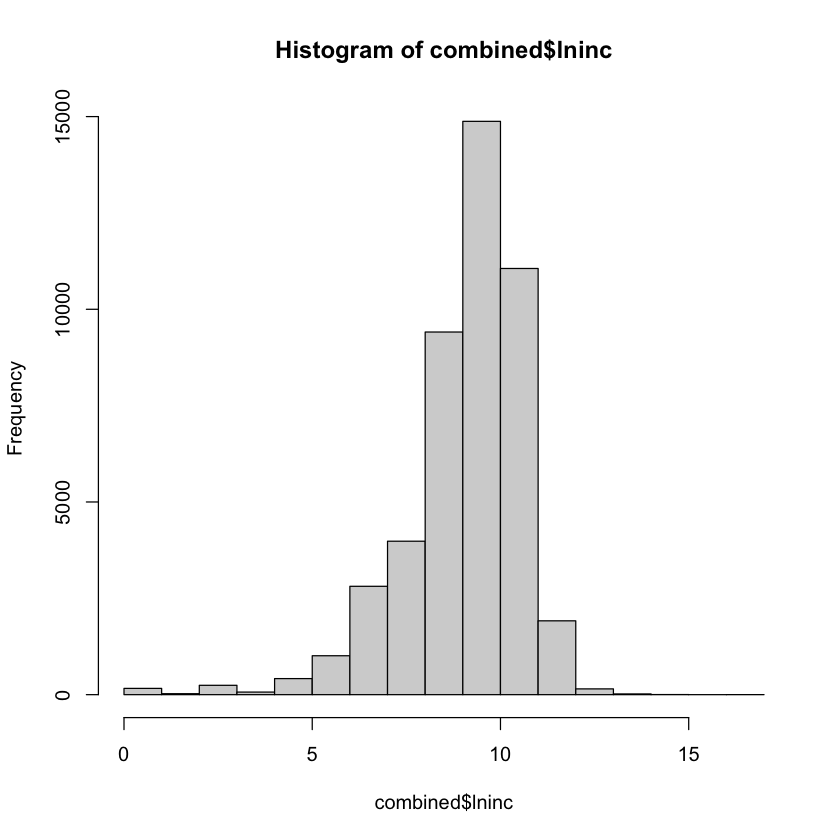

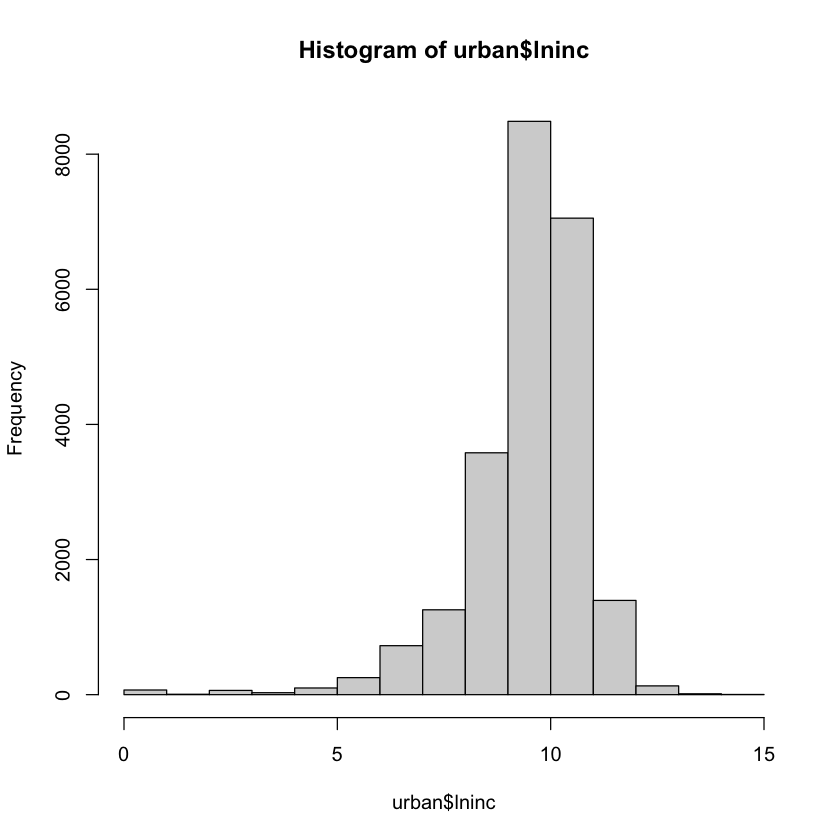

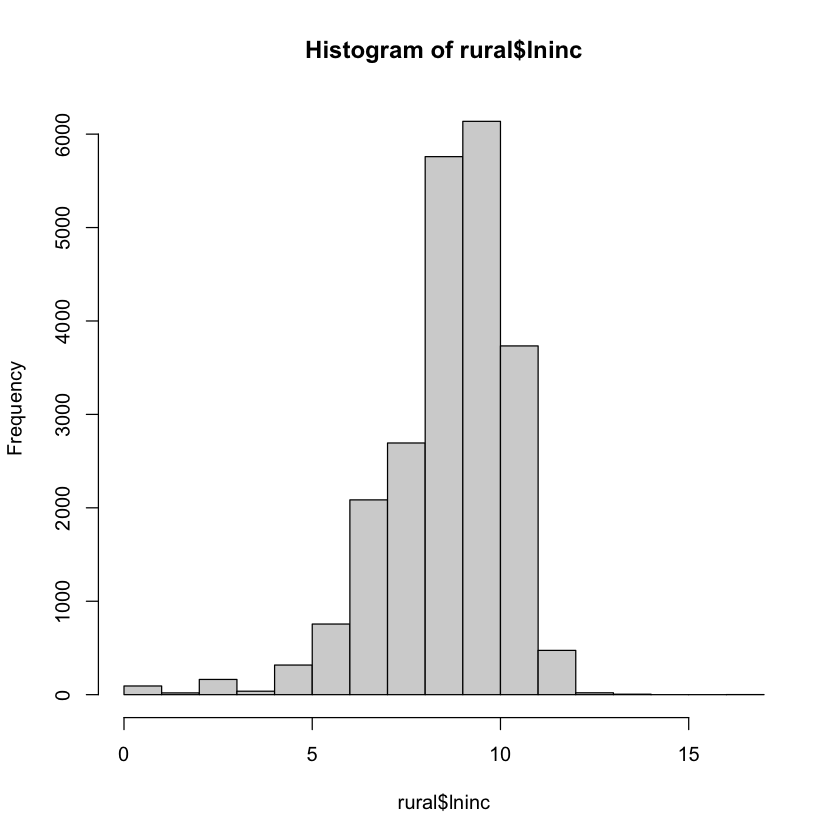

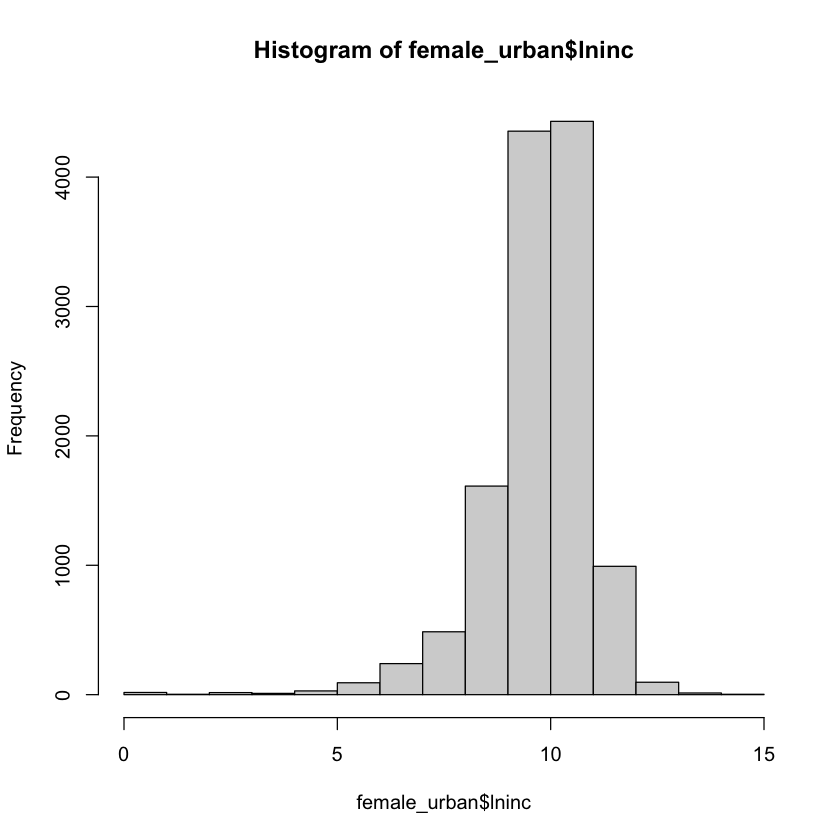

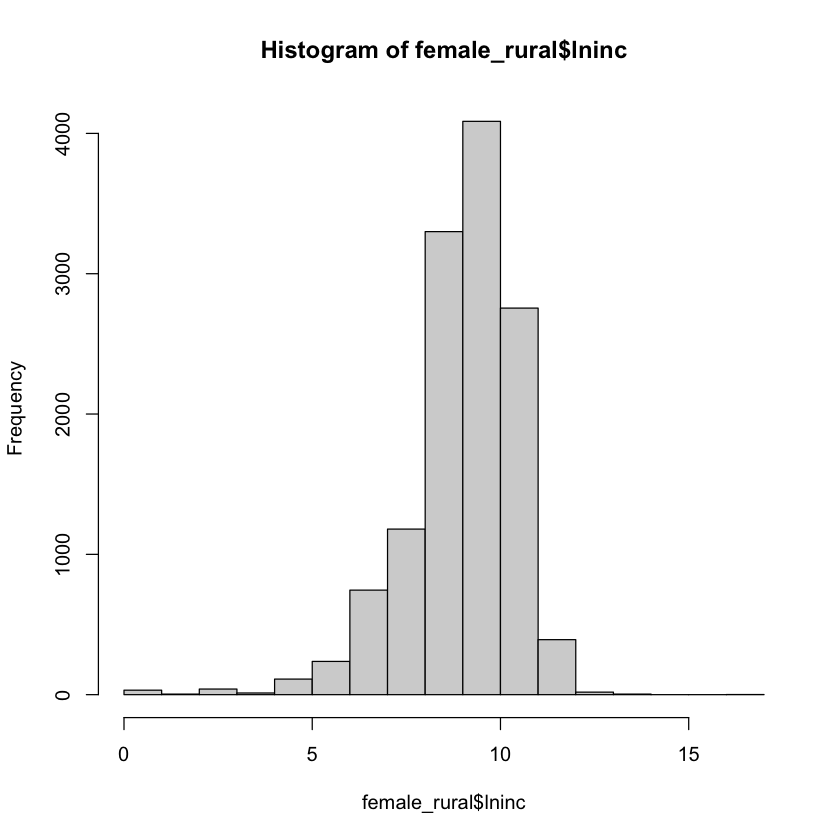

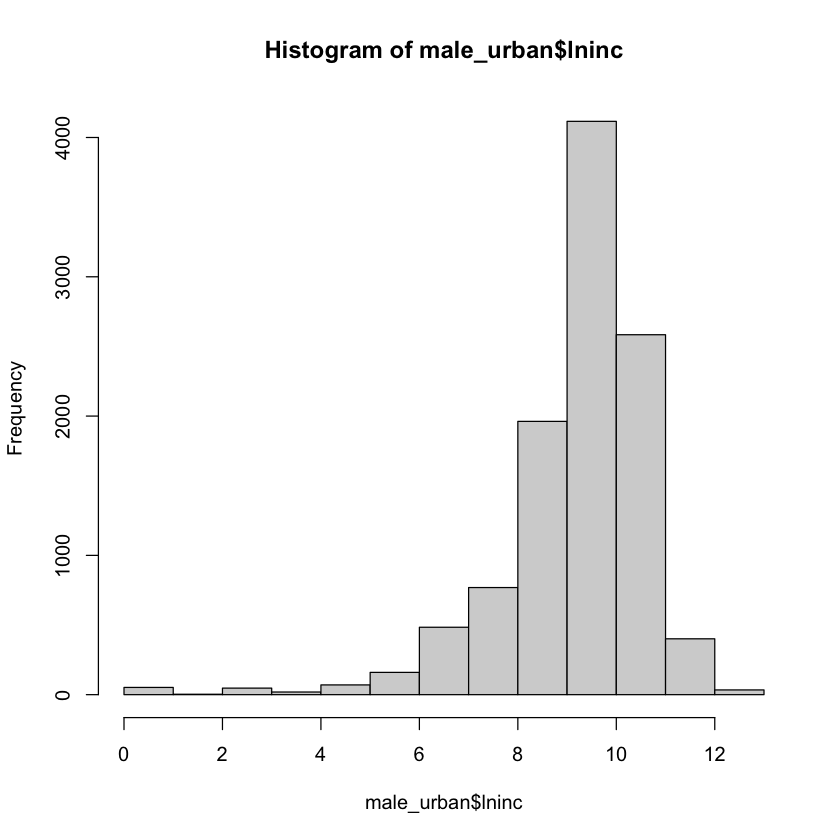

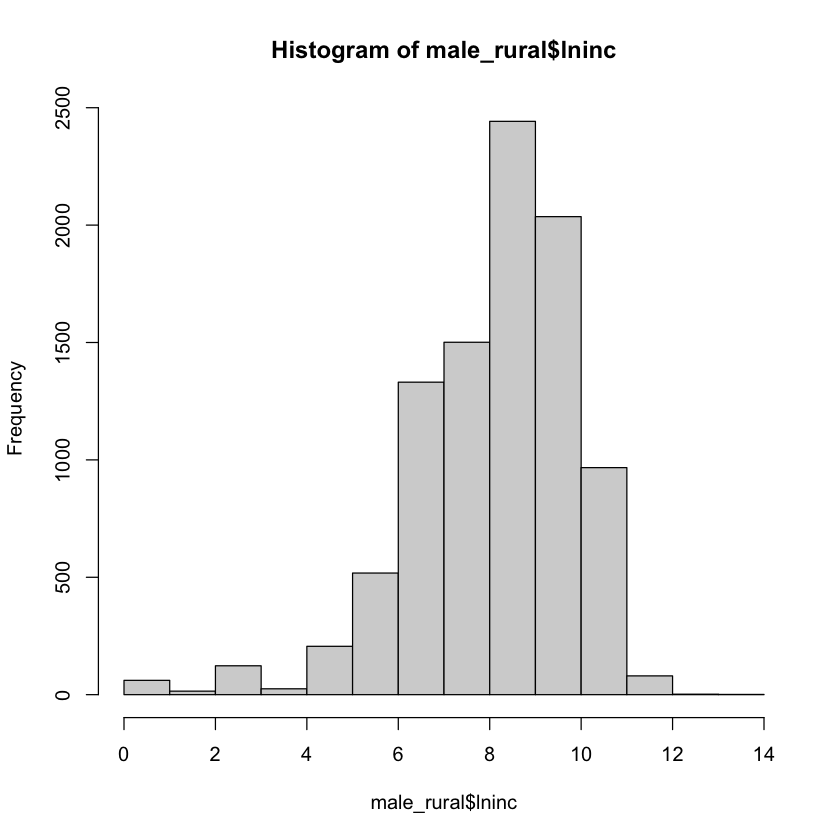

In [36]:
hist(combined$lninc)
hist(urban$lninc)
hist(rural$lninc)
hist(female_urban$lninc)
hist(female_rural$lninc)
hist(male_urban$lninc)
hist(male_rural$lninc)


## Running the regressions for lninc, rinc, lnrinc, pinc, and lnpinc on combined data, and urban and rural subsamples. Does not contain married or party variables

### Regression for lninc

In [38]:
lnincReg = filter(combined, !is.infinite(lninc) & !is.na(lninc))
summary(lm(lninc ~  postsecondary + seniorsecondary + juniorsecondary + primary + gender + urban + y10 + y12 + y14, data=lnincReg))

urban_reg = filter(urban, !is.infinite(lninc) & !is.na(lninc))
summary(lm(lninc ~  postsecondary + seniorsecondary + juniorsecondary + primary + gender + y10 + y12 + y14, data=urban_reg))

rural_reg = filter(rural, !is.infinite(lninc) & !is.na(lninc))
summary(lm(lninc ~  postsecondary + seniorsecondary + juniorsecondary + primary + gender + y10 + y12 + y14, data=rural_reg))

female_urban_reg = filter(female_urban, !is.infinite(lninc) & !is.na(lninc))
female_rural_reg = filter(female_rural, !is.infinite(lninc) & !is.na(lninc))
male_urban_reg = filter(male_urban, !is.infinite(lninc) & !is.na(lninc))
male_rural_reg = filter(male_rural, !is.infinite(lninc) & !is.na(lninc))
summary(lm(lninc ~  postsecondary + seniorsecondary + juniorsecondary + primary + y10 + y12 + y14, data=female_urban_reg))
summary(lm(lninc ~  postsecondary + seniorsecondary + juniorsecondary + primary + y10 + y12 + y14, data=female_rural_reg))
summary(lm(lninc ~  postsecondary + seniorsecondary + juniorsecondary + primary + y10 + y12 + y14, data=male_urban_reg))
summary(lm(lninc ~  postsecondary + seniorsecondary + juniorsecondary + primary + y10 + y12 + y14, data=male_rural_reg))


Call:
lm(formula = lninc ~ postsecondary + seniorsecondary + juniorsecondary + 
    primary + gender + urban + y10 + y12 + y14, data = lnincReg)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.5493  -0.5264   0.2281   0.8410   5.3336 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      8.797265   0.024534 358.578  < 2e-16 ***
postsecondary    1.732932   0.024212  71.574  < 2e-16 ***
seniorsecondary  1.265809   0.021949  57.670  < 2e-16 ***
juniorsecondary  1.050874   0.018734  56.093  < 2e-16 ***
primary          0.618875   0.020639  29.985  < 2e-16 ***
gender           0.283885   0.009443  30.064  < 2e-16 ***
urban            0.019081   0.005930   3.217  0.00129 ** 
y10             -1.089056   0.021248 -51.255  < 2e-16 ***
y12             -0.446978   0.022283 -20.059  < 2e-16 ***
y14             -1.361638   0.054684 -24.900  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.38


Call:
lm(formula = lninc ~ postsecondary + seniorsecondary + juniorsecondary + 
    primary + gender + y10 + y12 + y14, data = urban_reg)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.4944  -0.3971   0.1990   0.6733   4.4564 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)      8.99563    0.03223  279.08   <2e-16 ***
postsecondary    1.49882    0.02997   50.02   <2e-16 ***
seniorsecondary  1.05557    0.02905   36.33   <2e-16 ***
juniorsecondary  0.88624    0.02711   32.70   <2e-16 ***
primary          0.55341    0.03122   17.73   <2e-16 ***
gender           0.24503    0.01227   19.96   <2e-16 ***
y10             -0.80633    0.02533  -31.84   <2e-16 ***
y12             -0.26977    0.02643  -10.21   <2e-16 ***
y14             -1.71081    0.07923  -21.59   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.242 on 23150 degrees of freedom
Multiple R-squared:  0.1986,	Adjusted R-squar


Call:
lm(formula = lninc ~ postsecondary + seniorsecondary + juniorsecondary + 
    primary + gender + y10 + y12 + y14, data = rural_reg)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.8980 -0.6364  0.2286  0.8992  5.5796 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)      8.85449    0.03690  239.93   <2e-16 ***
postsecondary    1.33277    0.05009   26.61   <2e-16 ***
seniorsecondary  1.04356    0.03552   29.38   <2e-16 ***
juniorsecondary  0.94789    0.02609   36.33   <2e-16 ***
primary          0.56980    0.02716   20.98   <2e-16 ***
gender           0.38078    0.01434   26.55   <2e-16 ***
y10             -1.40198    0.03401  -41.23   <2e-16 ***
y12             -0.66265    0.03585  -18.48   <2e-16 ***
y14             -2.65111    0.09400  -28.20   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.448 on 22284 degrees of freedom
Multiple R-squared:  0.2376,	Adjusted R-squared:  0.237


Call:
lm(formula = lninc ~ postsecondary + seniorsecondary + juniorsecondary + 
    primary + y10 + y12 + y14, data = female_urban_reg)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.4420  -0.3562   0.1734   0.6363   4.4840 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)      9.48845    0.04226 224.499   <2e-16 ***
postsecondary    1.25608    0.04057  30.958   <2e-16 ***
seniorsecondary  0.81127    0.03938  20.601   <2e-16 ***
juniorsecondary  0.72650    0.03710  19.580   <2e-16 ***
primary          0.35789    0.04175   8.572   <2e-16 ***
y10             -0.73316    0.03114 -23.543   <2e-16 ***
y12             -0.30250    0.03248  -9.314   <2e-16 ***
y14             -1.33373    0.09561 -13.950   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.132 on 12387 degrees of freedom
Multiple R-squared:  0.1498,	Adjusted R-squared:  0.1493 
F-statistic: 311.8 on 7 and 12387 DF,  p-value


Call:
lm(formula = lninc ~ postsecondary + seniorsecondary + juniorsecondary + 
    primary + y10 + y12 + y14, data = female_rural_reg)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.5980 -0.5356  0.2405  0.8424  5.6423 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)      9.36113    0.04409  212.31   <2e-16 ***
postsecondary    1.14427    0.06011   19.04   <2e-16 ***
seniorsecondary  0.94628    0.04176   22.66   <2e-16 ***
juniorsecondary  0.85130    0.03236   26.30   <2e-16 ***
primary          0.48013    0.03405   14.10   <2e-16 ***
y10             -1.31387    0.03962  -33.16   <2e-16 ***
y12             -0.61447    0.04153  -14.80   <2e-16 ***
y14             -2.29392    0.11752  -19.52   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.303 on 12909 degrees of freedom
Multiple R-squared:  0.1981,	Adjusted R-squared:  0.1977 
F-statistic: 455.6 on 7 and 12909 DF,  p-value: < 2.2e-1


Call:
lm(formula = lninc ~ postsecondary + seniorsecondary + juniorsecondary + 
    primary + y10 + y12 + y14, data = male_urban_reg)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.4816  -0.3791   0.2467   0.7425   4.3309 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)      8.84775    0.04812 183.863  < 2e-16 ***
postsecondary    1.63390    0.04424  36.936  < 2e-16 ***
seniorsecondary  1.18685    0.04296  27.625  < 2e-16 ***
juniorsecondary  0.89749    0.03975  22.577  < 2e-16 ***
primary          0.62488    0.04677  13.361  < 2e-16 ***
y10             -0.87725    0.04052 -21.649  < 2e-16 ***
y12             -0.26280    0.04234  -6.207 5.61e-10 ***
y14             -2.19469    0.12995 -16.888  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.332 on 10693 degrees of freedom
Multiple R-squared:  0.2153,	Adjusted R-squared:  0.2148 
F-statistic: 419.1 on 7 and 10693 DF,  p-value: 


Call:
lm(formula = lninc ~ postsecondary + seniorsecondary + juniorsecondary + 
    primary + y10 + y12 + y14, data = male_rural_reg)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.8023 -0.7819  0.3052  1.0189  5.3141 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)      8.81971    0.06140  143.65   <2e-16 ***
postsecondary    1.48068    0.08454   17.52   <2e-16 ***
seniorsecondary  0.98258    0.06398   15.36   <2e-16 ***
juniorsecondary  0.89573    0.04347   20.60   <2e-16 ***
primary          0.53316    0.04422   12.06   <2e-16 ***
y10             -1.52397    0.05906  -25.80   <2e-16 ***
y12             -0.83170    0.06301  -13.20   <2e-16 ***
y14             -3.00963    0.14965  -20.11   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.593 on 9300 degrees of freedom
Multiple R-squared:  0.1971,	Adjusted R-squared:  0.1965 
F-statistic: 326.2 on 7 and 9300 DF,  p-value: < 2.2e-16


In [39]:
index = c("combined", "urban", "rural", "female_urban", "female_rural", "male_urban", "male_rural")
mean_lninc = c(mean(lnincReg$lninc), mean(urban_reg$lninc), mean(rural_reg$lninc), mean(female_urban_reg$lninc), mean(female_rural_reg$lninc), mean(male_urban_reg$lninc), mean(male_rural_reg$lninc))
median_lninc = c(median(lnincReg$lninc), median(urban_reg$lninc), median(rural_reg$lninc), median(female_urban_reg$lninc), median(female_rural_reg$lninc), median(male_urban_reg$lninc), median(male_rural_reg$lninc))
var_lninc = c(var(lnincReg$lninc), var(urban_reg$lninc), var(rural_reg$lninc), var(female_urban_reg$lninc), var(female_rural_reg$lninc), var(male_urban_reg$lninc), var(male_rural_reg$lninc))
kurtosis_lninc = c(kurtosis(lnincReg$lninc), kurtosis(urban_reg$lninc), kurtosis(rural_reg$lninc), kurtosis(female_urban_reg$lninc), kurtosis(female_rural_reg$lninc), kurtosis(male_urban_reg$lninc), kurtosis(male_rural_reg$lninc))
skew_lninc = c(skewness(lnincReg$lninc), skewness(urban_reg$lninc), skewness(rural_reg$lninc), skewness(female_urban_reg$lninc), skewness(female_rural_reg$lninc), skewness(male_urban_reg$lninc), skewness(male_rural_reg$lninc))

lninc = data.frame("subsamples"=index, "mean" = mean_lninc, "median" = median_lninc, "var" = var_lninc, "kurtosis" = kurtosis_lninc, "skew" = skew_lninc)
lninc$stdev = sqrt(lninc$var)

In [40]:
print("Lninc descriptive statistics")
print(lninc)

[1] "Lninc descriptive statistics"
    subsamples     mean   median      var kurtosis      skew    stdev
1     combined 9.061718 9.392662 2.511959 5.009130 -1.613858 1.584916
2        urban 9.468470 9.784704 1.923729 8.769189 -2.052226 1.386986
3        rural 8.621783 8.922658 2.748698 3.659157 -1.353109 1.657920
4 female_urban 9.714591 9.903488 1.506458 8.792632 -1.866556 1.227378
5 female_rural 9.000477 9.210340 2.116679 4.794995 -1.445970 1.454881
6   male_urban 9.180661 9.510445 2.259995 8.187224 -2.114384 1.503328
7   male_rural 8.096532 8.294050 3.157891 2.919475 -1.226031 1.777046


### Regression for rinc and lnrinc

In [ ]:
summary(lm(rinc ~  postsecondary + seniorsecondary + juniorsecondary + primary + gender + urban + y10 + y12 + y14, data=combined))
summary(lm(rinc ~  postsecondary + seniorsecondary + juniorsecondary + primary + gender + y10 + y12 + y14, data=urban))
summary(lm(rinc ~  postsecondary + seniorsecondary + juniorsecondary + primary + gender + y10 + y12 + y14, data=rural))

lnrincReg = filter(combined, !is.infinite(lnrinc) & !is.na(lnrinc))
urban_reg = filter(urban, !is.infinite(lnrinc) & !is.na(lnrinc))
rural_reg = filter(rural, !is.infinite(lnrinc) & !is.na(lnrinc))
summary(lm(lnrinc ~  postsecondary + seniorsecondary + juniorsecondary + primary + gender + urban + y10 + y12 + y14, data=lnrincReg))
summary(lm(lnrinc ~  postsecondary + seniorsecondary + juniorsecondary + primary + gender + y10 + y12 + y14, data=urban_reg))
summary(lm(lnrinc ~  postsecondary + seniorsecondary + juniorsecondary + primary + gender + y10 + y12 + y14, data=rural_reg))


female_urban_reg = filter(female_urban, !is.infinite(lnrinc) & !is.na(lnrinc))
female_rural_reg = filter(female_rural, !is.infinite(lnrinc) & !is.na(lnrinc))
male_urban_reg = filter(male_urban, !is.infinite(lnrinc) & !is.na(lnrinc))
male_rural_reg = filter(male_rural, !is.infinite(lnrinc) & !is.na(lnrinc))
summary(lm(lnrinc ~  postsecondary + seniorsecondary + juniorsecondary + primary + y10 + y12 + y14, data=female_urban_reg))
summary(lm(lnrinc ~  postsecondary + seniorsecondary + juniorsecondary + primary + y10 + y12 + y14, data=female_rural_reg))
summary(lm(lnrinc ~  postsecondary + seniorsecondary + juniorsecondary + primary + y10 + y12 + y14, data=male_urban_reg))
summary(lm(lnrinc ~  postsecondary + seniorsecondary + juniorsecondary + primary + y10 + y12 + y14, data=male_rural_reg))

In [ ]:
index = c("combined", "urban", "rural", "female_urban", "female_rural", "male_urban", "male_rural")
mean_lnrinc = c(mean(lnrincReg$lnrinc), mean(urban_reg$lnrinc), mean(rural_reg$lnrinc), mean(female_urban_reg$lnrinc), mean(female_rural_reg$lnrinc), mean(male_urban_reg$lnrinc), mean(male_rural_reg$lnrinc))
median_lnrinc = c(median(lnrincReg$lnrinc), median(urban_reg$lnrinc), median(rural_reg$lnrinc), median(female_urban_reg$lnrinc), median(female_rural_reg$lnrinc), median(male_urban_reg$lnrinc), median(male_rural_reg$lnrinc))
var_lnrinc = c(var(lnincReg$lnrinc), var(urban_reg$lnrinc), var(rural_reg$lnrinc), var(female_urban_reg$lnrinc), var(female_rural_reg$lnrinc), var(male_urban_reg$lnrinc), var(male_rural_reg$lnrinc))
kurtosis_lnrinc = c(kurtosis(lnrincReg$lnrinc), kurtosis(urban_reg$lnrinc), kurtosis(rural_reg$lnrinc), kurtosis(female_urban_reg$lnrinc), kurtosis(female_rural_reg$lnrinc), kurtosis(male_urban_reg$lnrinc), kurtosis(male_rural_reg$lnrinc))
skew_lnrinc = c(skewness(lnrincReg$lnrinc), skewness(urban_reg$lnrinc), skewness(rural_reg$lnrinc), skewness(female_urban_reg$lnrinc), skewness(female_rural_reg$lnrinc), skewness(male_urban_reg$lnrinc), skewness(male_rural_reg$lnrinc))

lnrinc = data.frame("subsamples"=index, "mean" = mean_lnrinc, "median" = median_lnrinc, "var" = var_lnrinc, "kurtosis" = kurtosis_lnrinc, "skew" = skew_lnrinc)
lnrinc$stdev = sqrt(lnrinc$var)

In [ ]:
print("Lnrinc descriptive statistics")
print(lnrinc)

### Regression for pinc and lnpinc

In [ ]:
summary(lm(pinc ~  postsecondary + seniorsecondary + juniorsecondary + primary + gender + urban + y10 + y12 + y14, data=combined))
summary(lm(pinc ~  postsecondary + seniorsecondary + juniorsecondary + primary + gender + y10 + y12 + y14, data=urban))
summary(lm(pinc ~  postsecondary + seniorsecondary + juniorsecondary + primary + gender + y10 + y12 + y14, data=rural))

lnpincReg = filter(combined, !is.infinite(lnpinc) & !is.na(lnpinc))
urban_reg = filter(urban, !is.infinite(lnpinc) & !is.na(lnpinc))
rural_reg = filter(rural, !is.infinite(lnpinc) & !is.na(lnpinc))
summary(lm(lnpinc ~  postsecondary + seniorsecondary + juniorsecondary + primary + gender + urban + y10 + y12 + y14, data=lnpincReg))
summary(lm(lnpinc ~  postsecondary + seniorsecondary + juniorsecondary + primary + gender + y10 + y12 + y14, data=urban_reg))
summary(lm(lnpinc ~  postsecondary + seniorsecondary + juniorsecondary + primary + gender + y10 + y12 + y14, data=rural_reg))


female_urban_reg = filter(female_urban, !is.infinite(lnpinc) & !is.na(lnpinc))
female_rural_reg = filter(female_rural, !is.infinite(lnpinc) & !is.na(lnpinc))
male_urban_reg = filter(male_urban, !is.infinite(lnpinc) & !is.na(lnpinc))
male_rural_reg = filter(male_rural, !is.infinite(lnpinc) & !is.na(lnpinc))
summary(lm(lnpinc ~  postsecondary + seniorsecondary + juniorsecondary + primary + y10 + y12 + y14, data=female_urban_reg))
summary(lm(lnpinc ~  postsecondary + seniorsecondary + juniorsecondary + primary + y10 + y12 + y14, data=female_rural_reg))
summary(lm(lnpinc ~  postsecondary + seniorsecondary + juniorsecondary + primary + y10 + y12 + y14, data=male_urban_reg))
summary(lm(lnpinc ~  postsecondary + seniorsecondary + juniorsecondary + primary + y10 + y12 + y14, data=male_rural_reg))

In [ ]:
index = c("combined", "urban", "rural", "female_urban", "female_rural", "male_urban", "male_rural")
mean_lnpinc = c(mean(lnpincReg$lnpinc), mean(urban_reg$lnpinc), mean(rural_reg$lnpinc), mean(female_urban_reg$lnpinc), mean(female_rural_reg$lnpinc), mean(male_urban_reg$lnpinc), mean(male_rural_reg$lnpinc))
median_lnpinc = c(median(lnpincReg$lnpinc), median(urban_reg$lnpinc), median(rural_reg$lnpinc), median(female_urban_reg$lnpinc), median(female_rural_reg$lnpinc), median(male_urban_reg$lnpinc), median(male_rural_reg$lnpinc))
var_lnpinc = c(var(lnpincReg$lnpinc), var(urban_reg$lnpinc), var(rural_reg$lnpinc), var(female_urban_reg$lnpinc), var(female_rural_reg$lnpinc), var(male_urban_reg$lnpinc), var(male_rural_reg$lnpinc))
kurtosis_lnpinc = c(kurtosis(lnpincReg$lnpinc), kurtosis(urban_reg$lnpinc), kurtosis(rural_reg$lnpinc), kurtosis(female_urban_reg$lnpinc), kurtosis(female_rural_reg$lnpinc), kurtosis(male_urban_reg$lnpinc), kurtosis(male_rural_reg$lnpinc))
skew_lnpinc = c(skewness(lnpincReg$lnpinc), skewness(urban_reg$lnpinc), skewness(rural_reg$lnpinc), skewness(female_urban_reg$lnpinc), skewness(female_rural_reg$lnpinc), skewness(male_urban_reg$lnpinc), skewness(male_rural_reg$lnpinc))

lnpinc = data.frame("subsamples"=index, "mean" = mean_lnpinc, "median" = median_lnpinc, "var" = var_lnpinc, "kurtosis" = kurtosis_lnpinc, "skew" = skew_lnpinc)
lnpinc$stdev = sqrt(lnpinc$var)

In [ ]:
print("Lnpinc descriptive statistics")
print(lnpinc)